In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import cv2
from skimage.util import random_noise
import os
import shutil

In [3]:
import seaborn as sns

def color_labels(label, max_id = 40):
    colored_label = np.zeros((label.shape[0], label.shape[1], 3))
    colors = sns.color_palette("CMRmap", max_id)
    for i in range(0, max_id):
        colored_label[label == i] = colors[i]
    return colored_label

In [4]:
def generate_random_img(W, H, num_gaussians=10, noise_level=0.2):
    # Generate a grid of coordinates
    x = np.linspace(-3, 3, W)
    y = np.linspace(-3, 3, H)
    X, Y = np.meshgrid(x, y)

    # Generate random Gaussians
    gaussians = []
    for _ in range(num_gaussians):
        x0 = np.random.uniform(-3, 3)
        y0 = np.random.uniform(-3, 3)
        sigma = np.random.uniform(0.1, 1.0)
        gaussian = np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
        gaussians.append(gaussian)

    # Combine random Gaussians and other patterns
    image = np.sum(gaussians, axis=0)
    image += np.random.rand(H, W) * noise_level  # Add some random noise

    # Normalize the image to [0, 1]
    image -= np.min(image)
    image /= np.max(image)

    return image

In [5]:
class SyntheticArrows:
  def __init__(self, WW = 1024, HH = 1024, W = 512, H = 512, init_objects = 40, min_diameter = 10, max_diameter = 60, speed_coeff = 0.4, rot_coeff = 1, max_aang = 10):
    self.WW = WW
    self.HH = HH
    self.W = W
    self.H = H
    self.min_diameter = min_diameter
    self.max_diameter = max_diameter
    self.rot_coeff = rot_coeff
    self.max_aang = max_aang
    self.max_id = 0
    self.background = generate_random_img(W,H)*100

    self.arrows = []
    for i in range(init_objects):
      arrow = {}
      arrow['diameter'] = random.randint(self.min_diameter,self.max_diameter)
      arrow['px'] = random.randint(-int((self.WW-self.W)/2)+arrow['diameter'], self.W+int((self.WW-self.W)/2)-arrow['diameter'])
      arrow['py'] = random.randint(-int((self.HH-self.H)/2)+arrow['diameter'], self.H+int((self.HH-self.H)/2)-arrow['diameter'])
      arrow['vx'] = random.randint(self.min_diameter, self.max_diameter) * speed_coeff * (-1 if random.random() < 0.5 else 1)
      arrow['vy'] = random.randint(self.min_diameter, self.max_diameter) * speed_coeff * (-1 if random.random() < 0.5 else 1)
      arrow['aang'] = 0
      arrow['id'] = self.max_id
      arrow['color'] = random.randint(100,255)
      self.max_id+=1
      self.arrows.append(arrow)

  def step(self):
    for i in range(len(self.arrows)):

      if random.randint(0,2) == 0:
        self.arrows[i]['diameter'] += 1

      aang_good = True
      if self.arrows[i]['aang'] >= self.max_aang:
        self.arrows[i]['aang'] += -(random.random())*self.rot_coeff
        aang_good = False
      if self.arrows[i]['aang'] <= -self.max_aang:
        self.arrows[i]['aang'] += (random.random())*self.rot_coeff
        aang_good = False
      if aang_good:
        self.arrows[i]['aang'] += (random.random()*2-1)*self.rot_coeff

      theta_rad = math.radians(self.arrows[i]['aang'])
      vx_new = self.arrows[i]['vx'] * math.cos(theta_rad) - self.arrows[i]['vy'] * math.sin(theta_rad)
      vy_new = self.arrows[i]['vx'] * math.sin(theta_rad) + self.arrows[i]['vy'] * math.cos(theta_rad)
      self.arrows[i]['vx'] = vx_new
      self.arrows[i]['vy'] = vy_new

      if self.arrows[i]['px'] < -int((self.WW-self.W)/2):
        self.arrows[i]['vx'] = -self.arrows[i]['vx']
      if self.arrows[i]['py'] < -int((self.HH-self.H)/2):
        self.arrows[i]['vy'] = -self.arrows[i]['vy']
      if self.arrows[i]['px'] > self.W+int((self.WW-self.W)/2):
        self.arrows[i]['vx'] = -self.arrows[i]['vx']
      if self.arrows[i]['py'] > self.H+int((self.HH-self.H)/2):
        self.arrows[i]['vy'] = -self.arrows[i]['vy']

      self.arrows[i]['px'] += self.arrows[i]['vx']
      self.arrows[i]['py'] += self.arrows[i]['vy']

  def render(self):
    img = np.copy(self.background)
    label = np.zeros((self.W,self.H))
    for arrow in self.arrows:
      arrow_center = (arrow['px'], arrow['py'])
      arrow_size = arrow['diameter']
      arrow_angle = math.atan2(arrow['vy'], arrow['vx'])

      p1 = (int(arrow_center[0] + arrow_size * math.cos(arrow_angle)),
            int(arrow_center[1] + arrow_size * math.sin(arrow_angle)))
      p2 = (int(arrow_center[0] + arrow_size * 0.3 * math.cos(arrow_angle + 2 * math.pi / 3)),
            int(arrow_center[1] + arrow_size * 0.3 * math.sin(arrow_angle + 2 * math.pi / 3)))
      p3 = (int(arrow_center[0] + arrow_size * 0.3 * math.cos(arrow_angle - 2 * math.pi / 3)),
            int(arrow_center[1] + arrow_size * 0.3 * math.sin(arrow_angle - 2 * math.pi / 3)))

      cv2.fillConvexPoly(img, np.array([p1, p2, p3], dtype=np.int32), color=arrow['color'])
      cv2.fillConvexPoly(label, np.array([p1, p2, p3], dtype=np.int32), color=arrow['id'])

    img = cv2.min(img+generate_random_img(self.W,self.H)*20, np.ones((self.W,self.H))*255)

    img = np.array(img, dtype='uint8')
    label = np.array(label, dtype='uint8')

    return img, label


In [ ]:
init_objects = 40
arrows = SyntheticArrows(init_objects = init_objects)

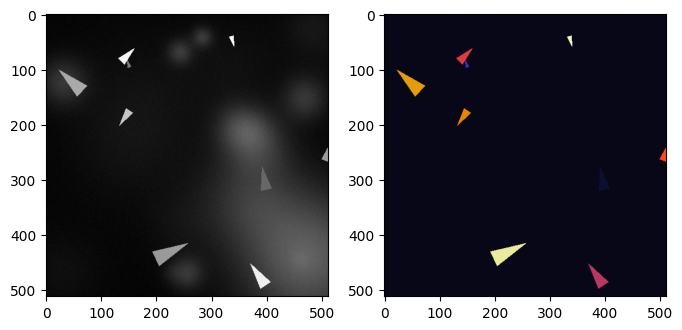

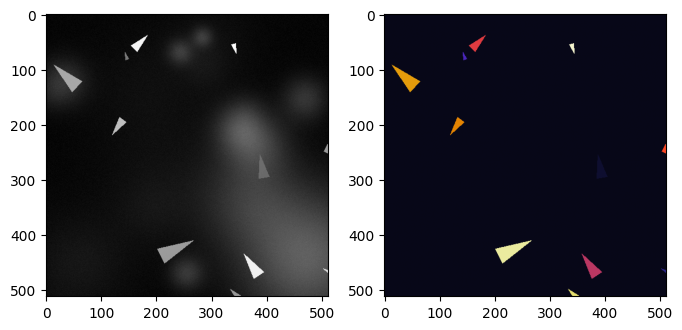

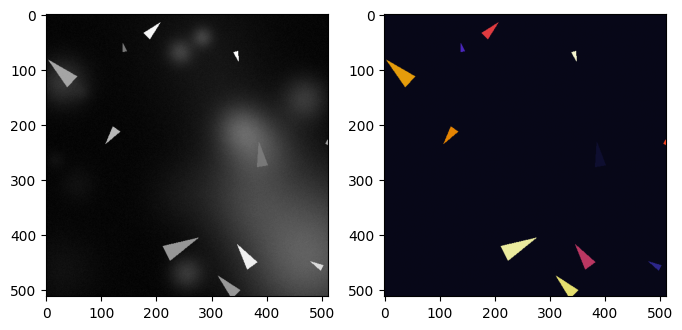

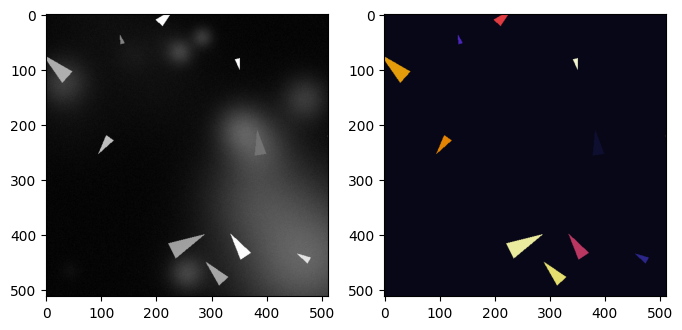

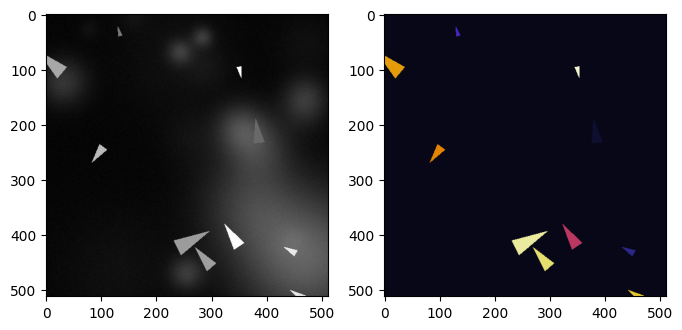

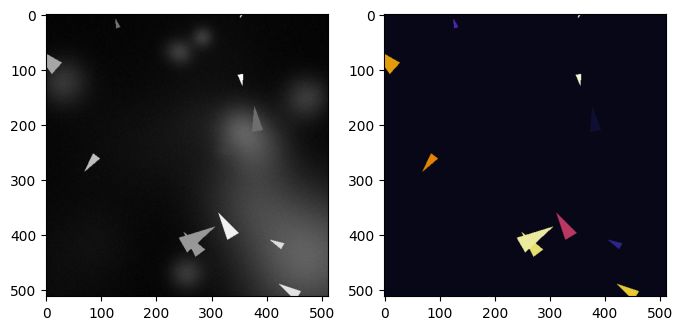

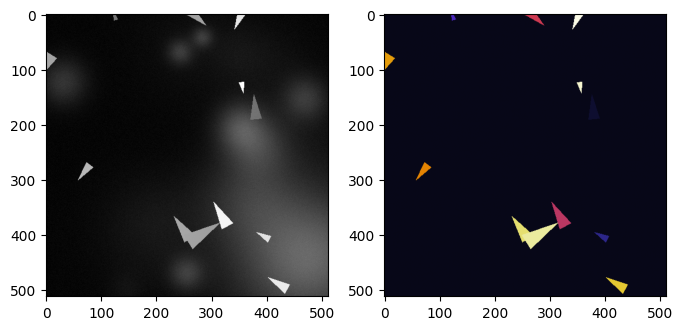

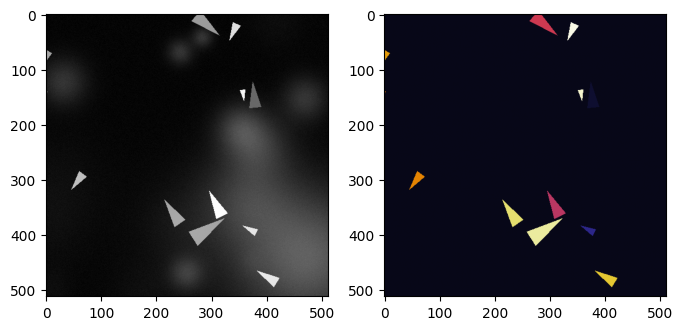

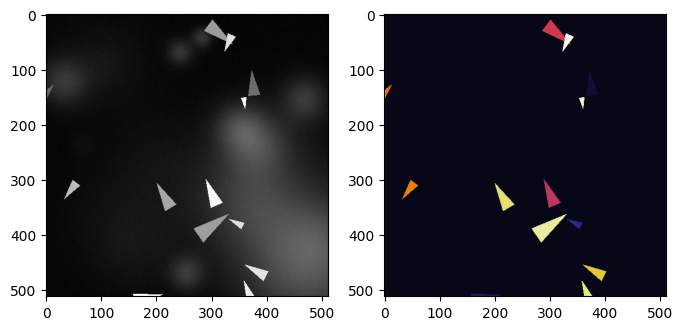

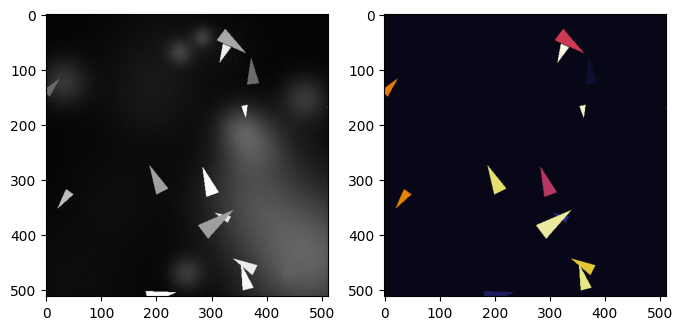

In [ ]:
#@title Display generated dataset

for t in range(10):
  img, label = arrows.render()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
  ax1.imshow(img, cmap='gray')
  ax2.imshow(color_labels(label, max_id = init_objects))
  plt.show()
  print()

  arrows.step()

In [ ]:
#@title Save generated dataset as video

def generate_frames(arrows, init_objects, num_frames):
    frames = []
    for _ in range(num_frames):
        img, label = arrows.render()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.imshow(img, cmap='gray')
        ax2.imshow(color_labels(label, max_id = init_objects))

        fig.canvas.draw()  # Draw the figure to update the plot
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        frames.append(frame)

        arrows.step()

    return frames

frames = generate_frames(arrows, init_objects, num_frames=100)

height, width, _ = frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('arrows_video.mp4', fourcc, 25.0, (width, height))

for frame in frames:
    out.write(frame)

out.release()

In [ ]:
#@title Generate Dataset

train_root = './SyntheticArrows_train_samples/'
test_root = './SyntheticArrows_test_samples/'

if os.path.exists(train_root):
  shutil.rmtree(train_root)
os.makedirs(train_root)

if os.path.exists(test_root):
  shutil.rmtree(test_root)
os.makedirs(test_root)

for sample_id in range(1,81):
  sample_folder = os.path.join(train_root, f"{sample_id:03d}/")
  imgs_folder = os.path.join(sample_folder, "imgs/")
  label_folder = os.path.join(sample_folder, "labels/")
  os.makedirs(sample_folder)
  os.makedirs(imgs_folder)
  os.makedirs(label_folder)

  init_objects = random.randint(30,50)
  arrows = SyntheticArrows(init_objects = init_objects)
  for t in range(100):
    img, label = arrows.render()
    img = Image.fromarray(img)
    label = Image.fromarray(label)
    img.save(os.path.join(imgs_folder, f"{sample_id:03d}_{t:03d}_img.png"))
    label.save(os.path.join(label_folder, f"{sample_id:03d}_{t:03d}_label.png"))
    arrows.step()
  print(f"Train Sample {sample_id:03d} generated")

for sample_id in range(81,101):
  sample_folder = os.path.join(test_root, f"{sample_id:03d}/")
  imgs_folder = os.path.join(sample_folder, "imgs/")
  label_folder = os.path.join(sample_folder, "labels/")
  os.makedirs(sample_folder)
  os.makedirs(imgs_folder)
  os.makedirs(label_folder)

  init_objects = random.randint(30,50)
  arrows = SyntheticArrows(init_objects = init_objects)
  for t in range(100):
    img, label = arrows.render()
    img = Image.fromarray(img)
    label = Image.fromarray(label)
    img.save(os.path.join(imgs_folder, f"{sample_id:03d}_{t:03d}_img.png"))
    label.save(os.path.join(label_folder, f"{sample_id:03d}_{t:03d}_label.png"))
    arrows.step()
  print(f"Test Sample {sample_id:03d} generated")

In [ ]:
!zip -r SyntheticArrows_train_samples.zip ./SyntheticArrows_train_samples
!zip -r SyntheticArrows_test_samples.zip ./SyntheticArrows_test_samples

In [ ]:
!unzip -t SyntheticArrows_train_samples.zip
!unzip -t SyntheticArrows_test_samples.zip

In [ ]:
from google.colab import files
files.download('SyntheticArrows_train_samples.zip')
files.download('SyntheticArrows_test_samples.zip')